In [5]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from numpy.polynomial import Polynomial

import sys

sys.path.append('../')
from common_util import ProjectPaths,setup_plotting_format,setup_axis_default
paths = ProjectPaths()
sys.path.append(str(paths.STRUCTURAL_DATA))

from mech_prop_db import ultimate_tensile_strength_w,ultimate_tensile_strength,minimum_uniform_elongation
#ignore warnings and set preference for matplotlib styles
import warnings

warnings.filterwarnings("ignore")
setup_plotting_format()



#Constants for Unit Conversion
temperature = np.linspace(293.15,1300,100)
KSI_TO_MPA = 6.89476
NCM2_TO_MPA = 0.01
KGMM2_TO_MPA = 9.80665

#Read in various data sets and convert units

#ITER
_,iter_w_df_uts= ultimate_tensile_strength_w(temperature,return_data= True)
iter_wl10_df_uts = ultimate_tensile_strength(temperature)
iter_wl10_df_uts= pd.DataFrame(iter_wl10_df_uts,index = temperature,columns = ['UTS [MPa]'])

iter_w_min_unif_elongation = minimum_uniform_elongation(temperature)
iter_w_min_unif_elongation = pd.DataFrame(iter_w_min_unif_elongation,index = temperature,columns = ['Min Unif Elongation [%]'])

iter_w_df_uts = pd.read_csv(paths.STRUCTURAL_DATA.joinpath('w_iter_uts'),index_col= None,header = 0)

wl10_iter_uts = ultimate_tensile_strength(temperature)

#Younger + Write
younger_df_unirradiated = pd.read_csv(paths.STRUCTURAL_DATA.joinpath('younger_wright_data1.csv'),header = 0,index_col = 0)
younger_df_irradiated = pd.read_csv(paths.STRUCTURAL_DATA.joinpath('younger_wright_data2.csv'),header = 0,index_col = 0)

younger_df_unirradiated['Yield Strength [MPa]'] = NCM2_TO_MPA*younger_df_unirradiated['Yield Strength [N/cm^2] e3'].astype(float)*1e3
younger_df_unirradiated['UTS [MPa]'] = NCM2_TO_MPA*younger_df_unirradiated['Ultimate Tensile Strength [N/cm^2] e3'].astype(float)*1e3
younger_df_unirradiated['Test Temperature [C]'] = younger_df_unirradiated['Test Temperature [K]'].astype(float) + 273.15


younger_df_irradiated['Ultimate Tensile Strength [N/cm^2] e3'].loc[younger_df_irradiated['Ultimate Tensile Strength [N/cm^2] e3'].isna()]  \
    =younger_df_irradiated['Brittle Fracture Strength [N/cm^2] e3'].loc[younger_df_irradiated['Ultimate Tensile Strength [N/cm^2] e3'].isna()] 

younger_df_irradiated['Ultimate Tensile Strength [N/cm^2] e3'].loc[younger_df_irradiated['Ultimate Tensile Strength [N/cm^2] e3'].isna()] \
    = younger_df_irradiated['Lower Yield Point [N/cm^2] e3'].loc[younger_df_irradiated['Ultimate Tensile Strength [N/cm^2] e3'].isna()] 

younger_df_irradiated['Yield Strength [MPa]'] = NCM2_TO_MPA*younger_df_irradiated['Yield Strength [N/cm^2] e3'].astype(float)*1e3
younger_df_irradiated['UTS [MPa]'] = NCM2_TO_MPA*younger_df_irradiated['Ultimate Tensile Strength [N/cm^2] e3'].astype(float)*1e3

younger_df_irradiated['Test Temperature [C]'] = younger_df_irradiated['Test Temperature [K]'].astype(float) + 273.15

#Mabouchi
mabuchi_wdf = pd.read_csv(paths.STRUCTURAL_DATA.joinpath('mabuchi_w.csv'))
mabuchi_wL10df = pd.read_csv(paths.STRUCTURAL_DATA.joinpath('mabuchi_wl10.csv'))

#Nogami
nogami_df = pd.read_csv(paths.STRUCTURAL_DATA.joinpath('nogami_data.csv'),index_col = 0)

#Haibany
habainy_df = pd.read_csv(paths.STRUCTURAL_DATA.joinpath('habainy.csv'))

#Yin
yin_df = pd.read_csv(paths.STRUCTURAL_DATA.joinpath('yin_data2020.csv')).iloc[8:]
for column in yin_df.columns:
    if column not in ['Materials']:
        yin_df[column].iloc[yin_df[column] == '�'] = np.nan
        yin_df[column] = yin_df[column].astype(float)

#Miyazawa
miyazawa_df = pd.read_csv(paths.STRUCTURAL_DATA.joinpath('miyazawa_data2020.csv'))
for column in miyazawa_df.columns:
    if column not in ['Sample ID','Material type']:
        miyazawa_df[column].iloc[miyazawa_df[column] == '�'] = np.nan
        miyazawa_df[column] = miyazawa_df[column].astype(float)


#Ratcliff
ratcliff_df = pd.read_csv(paths.STRUCTURAL_DATA.joinpath('ratcliff/uts_bounds.csv'),index_col = 0)

### Temperature Dependent Ultimate Tensile Stress
Plotted below is the ultimate tensile strength of various tungsten alloys, produced in a variety of ways, as a function of temperature. The scatter visually confirms that a low order polynomial dependence upon temperature may provide an adquete model.

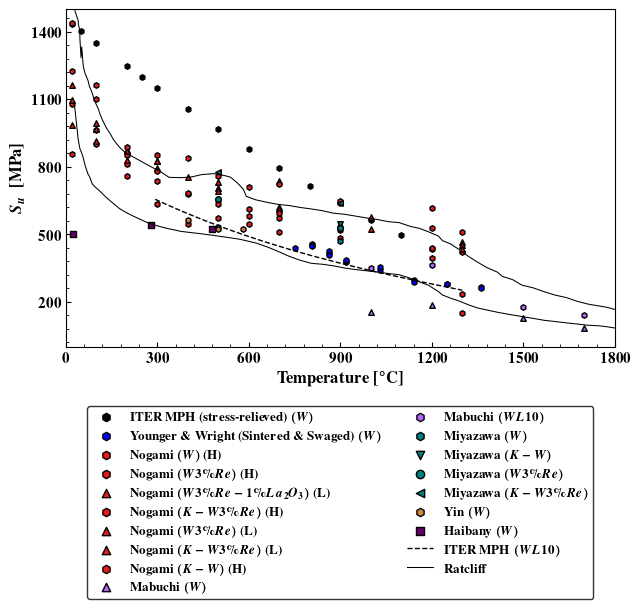

In [10]:
import pickle
import matplotlib
import copy
MARKER_SIZE = 16
ALPHA = 1.0

fig,axes = plt.subplots(nrows =  2,figsize = (6.5,6.25),height_ratios = [1,0.4])
axes[0].set_xlabel(r'\textbf{Temperature} \textbf{[}$^\circ$\textbf{C]}',fontsize = 12)
axes[0].set_ylabel(r'$S_u$ \ \textbf{[MPa]}',fontsize  = 12)
ax = axes[0]
setup_axis_default(ax)
label_axes = axes[1]

#davis
ax.scatter(iter_w_df_uts['T [C]'],iter_w_df_uts['UTS (stress-relieved) [MPA]'],
            edgecolor = 'k',facecolor = 'black', s = MARKER_SIZE,label = 'ITER MPH (stress-relieved) $(W)$',
            marker = 'h',alpha = ALPHA)


#younger & wright
ax.scatter(younger_df_unirradiated['Test Temperature [C]'],younger_df_unirradiated['UTS [MPa]'],
            edgecolor = 'k', facecolor = 'blue', s = MARKER_SIZE,label = r'Younger \& Wright (Sintered \& Swaged)  $(W)$',
            marker = 'h',alpha = ALPHA)
         
#Nogami
alloys = {'UTS [MPa] W Plate (H)':('Nogami $(W)$ (H)','h'),
          'UTS [MPa] W3%Re Plate (H)':(r'Nogami  $(W3\%Re)$ (H)','h'),
          'UTS [MPa] W3%Re-1%La2O3 Plate (L)':(r'Nogami $(W3\%Re-1\%La_2O_3)$ (L)','^'),
          'UTS [MPa] K-W3%Re Plate (H)':(r'Nogami $(K-W3\%Re)$ (H)','h'),
          'UTS [MPa] W3%Re Plate (L)':(r'Nogami $(W3\%Re)$ (L)','^'),
          'UTS [MPa] K-W3%Re Plate (L)': (r'Nogami $(K-W3\%Re)$ (L)','^'),
          'UTS [MPa] K-W Plate (H)': (r'Nogami $(K-W)$ (H)','h'),
}

colors = plt.get_cmap('Set1')(np.arange(0,1,1/8))
i = 0
for column,(label,marker) in alloys.items():
        ax.scatter(nogami_df.index,nogami_df[column],
                edgecolor = 'k', facecolor = colors[i], s = MARKER_SIZE,label = label,
                marker = marker,alpha = ALPHA)

#Mabuchi

ax.scatter(mabuchi_wdf['T [K]'] - 273.15,mabuchi_wdf['UTS [Mpa]'],edgecolor = 'k',
           facecolor = (178/255,102/255,1),s=MARKER_SIZE,label = 'Mabuchi  $(W)$',
           marker = '^',alpha = ALPHA)

ax.scatter(mabuchi_wL10df['T [K]'] - 273.15,mabuchi_wL10df['UTS [Mpa]'],edgecolor = 'k',
           facecolor = (178/255,102/255,1),s=MARKER_SIZE,label = 'Mabuchi $(WL10)$',
           marker = 'h',alpha = ALPHA)



#Miyazawa
unirrad = np.isnan(miyazawa_df['dose [dpa]'].to_numpy())

alloys = {'Pure W (SR)':('Miyazawa $(W)$','h'),
          'K-doped W (SR)':('Miyazawa $(K-W)$','v'),
          'W-3%Re (SR)':('Miyazawa $(W3\%Re)$','o'),
          'K-doped W-3%Re (SR)':('Miyazawa $(K-W3\%Re)$','<')}

ai = miyazawa_df['Material type']== 'Pure W (SR)'

for column,(label,marker) in alloys.items():
        ai = miyazawa_df['Material type']== column    
        alloy_index = np.all(np.concatenate([unirrad[:,None],
                                        ai.to_numpy()[:,None]],axis = 1),
                        axis = 1)
        
        ax.scatter(miyazawa_df['Test temperature [C]'].loc[alloy_index],miyazawa_df['UTS [MPa]'].loc[alloy_index],edgecolor = 'k',
                facecolor = (0,128/255,128/255),s=MARKER_SIZE,label = label,
                marker = marker,alpha = ALPHA)


#Yin data
unirrad = yin_df['Dose (dpa)'] == 0.0
ax.scatter(yin_df['Test temperature (oC)'].loc[unirrad],yin_df['UTS (MPa)'].loc[unirrad],edgecolor = 'k',
        facecolor = (205/255,133/255,63/255),s=MARKER_SIZE,label = r'Yin $(W)$',
        marker = 'h',alpha = ALPHA)

#Habainy Data
phdf = habainy_df.loc[habainy_df['Process'] == 'Forged']

phdf = phdf.loc[phdf['Surface'] == 'polished']

ax.scatter(phdf['T [C]'],phdf['UTS [Mpa]'],edgecolor = 'k',
        facecolor = (102/255,0,102/255),s=MARKER_SIZE,label = r'Haibany  $(W)$',
        marker = 's',alpha = ALPHA)

#ITER
ax.plot(temperature,wl10_iter_uts,linewidth = 1., color = 'k',linestyle = '--',
        label = 'ITER MPH $(WL10)$')

ax.plot(ratcliff_df.index,ratcliff_df['lb'],lw = 0.75,color = 'k',linestyle = '-')

ax.plot(ratcliff_df.index,ratcliff_df['ub'],lw = 0.75,color = 'k',linestyle = '-',
        label = 'Ratcliff')

#Formatting
ax.set_xticks(np.arange(0,2100,300))
ax.set_yticks(np.arange(200,1500,300))
ax.set_ylim([0,1500])

handles,labels = ax.get_legend_handles_labels()
legend = label_axes.legend(handles = handles,
                          labels = [r'\textbf{' + label + '}' for label in labels],
                          loc = 'center',ncol = 2,fontsize = 9.5,markerscale = 1.5)  

legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(1.0)
ax.set_xlim([0,1800])
label_axes.axis('off')
fig.tight_layout()
with open(paths.SCRATCH.joinpath('uts_data_fig.pkl'),'wb') as f:
    pickle.dump((fig,axes),f)



fig.savefig('../thesis_images/uts_data.svg',bbox_inches = 'tight')


### The Effect of Material Production Route

One of the primary difficulties in predicting the macroscopic material properties is the tendency of small differences in production methodology yielding remarkably different properties, despite otherwise identical composition. This phenonmenan is highlighted below for material ultimate tensile strength using data published by Nogami _et al_, where the materials highly deformed (H) and less deformed (L) during hot rolling. The impact of the different productions produces a visible, though inconsistent effect across alloys. 

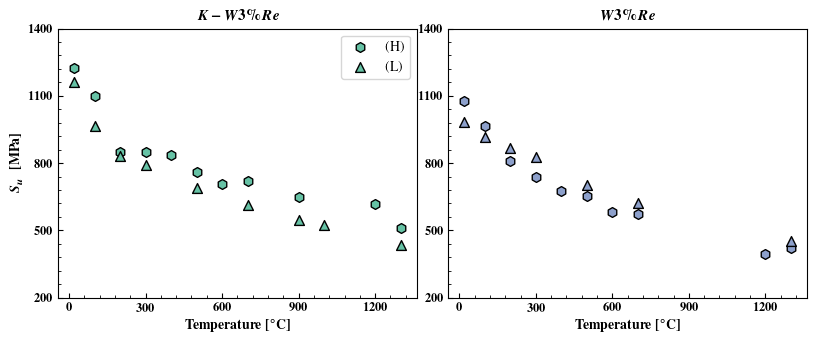

In [16]:
fig,axes = plt.subplots(ncols = 2,figsize = (8,3.25))
axes[0].set_ylabel(r'$S_u$ \ \textbf{[MPa]}',fontsize  = 10)
for ax in axes:
    ax.set_xlabel(r'\textbf{Temperature} \textbf{[}$^\circ$\textbf{C]}',fontsize = 10)
    ax.tick_params('both',labelsize = 9,direction = 'in',which = 'both')
    ax.set_xticks(np.arange(0,1300,300))
    ax.set_yticks(np.arange(200,1600,300))
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax.set_ylim([200,1400])

alloys = [('UTS [MPa] K-W3%Re Plate (H)','UTS [MPa] K-W3%Re Plate (L)','$K-W3\%Re$',0.1),
           ('UTS [MPa] W3%Re Plate (H)','UTS [MPa] W3%Re Plate (L)','$W3\%Re$',0.3)]

for ax,(high,low,label,color) in zip(axes,alloys):
    ax.scatter(nogami_df.index,nogami_df[high],
                edgecolor = 'k', facecolor = plt.get_cmap('Set2')(color), s = 50,label = '(H)',
                marker = 'h',alpha = ALPHA)
    ax.scatter(nogami_df.index,nogami_df[low],
                edgecolor = 'k', facecolor = plt.get_cmap('Set2')(color), s = 50,label = '(L)',
                marker = '^',alpha = ALPHA)
    ax.set_title(label,fontsize = 11)

axes[0].legend(fontsize = 10)  
fig.tight_layout(pad = 0.1)
